# 1. Import Libraries
We load all the Python packages needed for:
- Data handling (`pandas`, `numpy`)
- Machine learning (`sklearn`)
- Utility functions (`itertools`)


In [1]:
# Step 1: Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, classification_report
import itertools
import shap
from sklearn.utils import resample
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import joblib


# 2. Load Dataset
We import the dataset containing process-level information such as:
- Energy mix (coal %, hydro %)
- Transport mode and distance
- End-of-life treatment
- Recycled content percentage
This is our starting point for building the ML model.


In [2]:
file_path = "LCA_Input_Dataset_5000.csv"
df = pd.read_csv(file_path)

np.random.seed(42)

df['co2'] = 0.05*df['electricity_kWh_per_FU'] + \
            0.02*df['fuel_MJ_per_FU'] + \
            0.01*df['transport_distance_km'] - \
            0.03*df['recycled_content_pct'] + \
            np.random.normal(0,1,len(df))

df['energy'] = df['electricity_kWh_per_FU']*3.6 + df['fuel_MJ_per_FU'] + \
               np.random.normal(0,5,len(df))

df['water'] = 5 + 0.02*df['transport_distance_km'] + \
              0.05*df['product_lifetime_years'] + \
              np.random.normal(0,1,len(df))

df['is_circular'] = ((df['end_of_life_recycle_rate_pct'] > 50) | 
                     (df['product_lifetime_years'] > 15)).astype(int)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (5000, 20)


,project_name,functional_unit,metal,production_route,recycled_content_pct,electricity_kWh_per_FU,electricity_grid_region,fuel_MJ_per_FU,fuel_type,transport_mode,transport_distance_km,process_yield_pct,end_of_life_recycle_rate_pct,product_lifetime_years,region,data_confidence,co2,energy,water,is_circular
0,Al-proj-0001,1 tonne,Aluminium,mix,30,2078,US-Grid,1400,coal,rail,780,96,23,43,China,predicted,139.296714,8878.681202,22.071505,1
1,Al-proj-0002,1 tonne,Aluminium,mix,25,674,IN-Grid,562,oil,ship,1245,97,93,35,India,user,56.501736,2986.132929,31.344501,1
2,Co-proj-0003,1 tonne,Copper,mix,25,2192,CN-Grid,1595,coal,rail,1881,99,82,22,China,user,160.207689,9477.221784,43.122619,1
3,Co-proj-0004,1 tonne,Copper,secondary,46,5751,IN-Grid,1994,biomass,truck,361,86,57,6,Europe,extracted,331.183030,22695.949549,12.630418,1
4,Co-proj-0005,1 tonne,Copper,secondary,45,6210,CN-Grid,1248,oil,ship,367,99,75,37,Europe,predicted,337.545847,23607.664145,15.387179,1








# 3. Preprocess Data
We set up a preprocessing pipeline to:
- Encode categorical variables 
- Scale numerical variables 
This ensures the ML models can handle mixed data types correctly.


In [3]:
# Step 3: Split into features and targets
target_cols = ['co2', 'energy', 'water', 'is_circular']
X = df.drop(columns=target_cols)
y_co2 = df['co2']
y_energy = df['energy']
y_water = df['water']
y_circ = df['is_circular']


numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)


Numeric features: ['recycled_content_pct', 'electricity_kWh_per_FU', 'fuel_MJ_per_FU', 'transport_distance_km', 'process_yield_pct', 'end_of_life_recycle_rate_pct', 'product_lifetime_years']
Categorical features: ['project_name', 'functional_unit', 'metal', 'production_route', 'electricity_grid_region', 'fuel_type', 'transport_mode', 'region', 'data_confidence']


In [4]:
# Step 4: Preprocessing pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


# 4. Train ML Models
We train three regression models:
- `reg_co2`: Predicts CO₂ emissions (t/FU)
- `reg_energy`: Predicts energy demand (MJ/FU)
- `reg_water`: Predicts water consumption (m³/FU)

We also train a classification model `clf` to predict if a process is circular or not.


In [5]:
# Step 5: Train/Test split
X_train, X_test, y_co2_train, y_co2_test, y_energy_train, y_energy_test, y_water_train, y_water_test, y_circ_train, y_circ_test = \
    train_test_split(X, y_co2, y_energy, y_water, y_circ, test_size=0.2, random_state=42)


X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

reg_co2 = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_proc, y_co2_train)
reg_energy = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_proc, y_energy_train)
reg_water = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_proc, y_water_train)
clf = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train_proc, y_circ_train)

print("Model Performance:")
print("CO2 R²:", r2_score(y_co2_test, reg_co2.predict(X_test_proc)))
print("Energy R²:", r2_score(y_energy_test, reg_energy.predict(X_test_proc)))
print("Water R²:", r2_score(y_water_test, reg_water.predict(X_test_proc)))
print("\nCircularity classification report:\n", classification_report(y_circ_test, clf.predict(X_test_proc)))


Model Performance:
CO2 R²: 0.9996051735257988
Energy R²: 0.9998905834401801
Water R²: 0.9908670775776819

Circularity classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       921

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Energy R²: 0.9998905834401801
Water R²: 0.9908670775776819

Circularity classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       921

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



# 5. Evaluate Models
We test the models on validation data to check:
- Prediction accuracy
- R² scores
- Error margins
This confirms whether the trained models are reliable.


In [6]:
# Step 6: Prediction for one process (first row in dataset)
sample = X.iloc[0:1]
sample_proc = preprocessor.transform(sample)

pred = {
    "CO2 (t/FU)": round(reg_co2.predict(sample_proc)[0], 2),
    "Energy (MJ/FU)": round(reg_energy.predict(sample_proc)[0], 2),
    "Water (m³/FU)": round(reg_water.predict(sample_proc)[0], 2),
    "Circular?": "Yes" if clf.predict(sample_proc)[0] else "No"
}

print("Predictions for sample process:\n", pred)


Predictions for sample process:
 {'CO2 (t/FU)': np.float64(138.66), 'Energy (MJ/FU)': np.float64(8873.4), 'Water (m³/FU)': np.float64(22.42), 'Circular?': 'Yes'}


# 6. Scenario Testing
We apply the recommendation system to a sample process.
The output is a table comparing:
- Current scenario
- Improved scenarios
- Their predicted environmental impacts


In [7]:

# Step 8: Circularity evaluation & recommendations (Standard)

def evaluate_circularity(row, pred):
    recs = []
    
    if row['end_of_life_recycle_rate_pct'] < 50:
        recs.append("Increase end-of-life recycling rate above 50% to improve circularity.")
    if row['product_lifetime_years'] < 15:
        recs.append("Extend product lifetime (durability, repairability).")
    if row['electricity_grid_region'].lower() in ["coal", "mixed"] or row['electricity_kWh_per_FU'] > 5000:
        recs.append("Shift energy mix towards renewable or low-carbon sources.")
    if row['transport_mode'] == "truck" and row['transport_distance_km'] > 500:
        recs.append("Switch to rail/ship for long-distance transport.")
    if row['production_route'] == "primary" and row['recycled_content_pct'] < 30:
        recs.append("Use more recycled content instead of primary raw material.")
    
    if not recs:
        recs.append("Already highly circular.")
    
    return recs

# Test on a few random processes
samples = X.sample(3, random_state=42)

for i, (_, row) in enumerate(samples.iterrows(), start=1):
    sample_proc = preprocessor.transform(pd.DataFrame([row]))
    pred = {
        "CO2 (t/FU)": round(reg_co2.predict(sample_proc)[0], 2),
        "Energy (MJ/FU)": round(reg_energy.predict(sample_proc)[0], 2),
        "Water (m³/FU)": round(reg_water.predict(sample_proc)[0], 2),
        "Circular?": "Yes" if clf.predict(sample_proc)[0] else "No"
    }
    
    print(f"\nProcess {i}: {row['project_name']} ({row['metal']})")
    print("Functional unit:", row['functional_unit'])
    print("Predictions:", pred)
    print("Recommendations:")
    for rec in evaluate_circularity(row, pred):
        print(" -", rec)



Process 1: Co-proj-1502 (Copper)
Functional unit: 1 tonne
Predictions: {'CO2 (t/FU)': np.float64(144.63), 'Energy (MJ/FU)': np.float64(9419.58), 'Water (m³/FU)': np.float64(22.48), 'Circular?': 'Yes'}
Recommendations:
 - Extend product lifetime (durability, repairability).
 - Switch to rail/ship for long-distance transport.

Process 2: Al-proj-2587 (Aluminium)
Functional unit: 1 tonne
Predictions: {'CO2 (t/FU)': np.float64(404.21), 'Energy (MJ/FU)': np.float64(28682.92), 'Water (m³/FU)': np.float64(7.42), 'Circular?': 'Yes'}
Recommendations:
 - Shift energy mix towards renewable or low-carbon sources.

Process 3: Al-proj-2654 (Aluminium)
Functional unit: 1 tonne
Predictions: {'CO2 (t/FU)': np.float64(535.17), 'Energy (MJ/FU)': np.float64(37707.43), 'Water (m³/FU)': np.float64(32.85), 'Circular?': 'Yes'}
Recommendations:
 - Shift energy mix towards renewable or low-carbon sources.
 - Switch to rail/ship for long-distance transport.


# 7. Circularity Evaluation & Recommendations
We define rules to interpret the predictions:
- If recycling rate < 50% → recommend higher recycling
- If lifetime < 15 years → recommend extending durability
- If energy mix has high coal → recommend renewable sources
- If transport is truck over long distance → recommend rail/ship

The system produces human-readable improvement recommendations.


In [8]:
def recommend(current, preprocessor, reg_co2, reg_energy, reg_water):
    
    current = current.to_dict() if not isinstance(current, dict) else current


    coal = current.get("energy_coal_pct", 50)
    hydro = current.get("energy_hydro_pct", 100 - coal)
    rec = current.get("recycled_content_pct", 10)
    eol = current.get("end_of_life", "landfill")

    rec_options = [rec, min(100, rec+20)]
    coal_options = [coal, max(0, coal-20)]
    eol_options = ["landfill", "recycle"]

    scenarios = []
    for r, c, e in itertools.product(rec_options, coal_options, eol_options):
        scenario = current.copy()
        scenario["recycled_content_pct"] = r
        scenario["energy_coal_pct"] = c
        scenario["energy_hydro_pct"] = 100 - c
        scenario["end_of_life"] = e
        scenarios.append(scenario)

    df = pd.DataFrame(scenarios)
    X_proc = preprocessor.transform(df)
    df["pred_co2"] = reg_co2.predict(X_proc)
    df["pred_energy"] = reg_energy.predict(X_proc)
    df["pred_water"] = reg_water.predict(X_proc)

    return df.sort_values(by="pred_co2").reset_index(drop=True)


# 8. Recommendation System
We build a scenario generator that:
- Increases recycled content by +20%
- Reduces coal share by -20%
- Changes end-of-life from landfill → recycle

For each scenario, the ML models predict impacts (CO₂, energy, water).
The results are ranked by lowest CO₂ emissions to suggest improvements.


In [9]:
current = df.iloc[0]  

recommendations = recommend(current, preprocessor, reg_co2, reg_energy, reg_water)



pd.set_option("display.max_columns", None)   
pd.set_option("display.width", 1000)
print(recommendations)


   project_name functional_unit      metal production_route  recycled_content_pct  electricity_kWh_per_FU electricity_grid_region  fuel_MJ_per_FU fuel_type transport_mode  transport_distance_km  process_yield_pct  end_of_life_recycle_rate_pct  product_lifetime_years region data_confidence         co2       energy      water  is_circular  energy_coal_pct  energy_hydro_pct end_of_life    pred_co2  pred_energy  pred_water
0  Al-proj-0001         1 tonne  Aluminium              mix                    50                    2078                 US-Grid            1400      coal           rail                    780                 96                            23                      43  China       predicted  139.296714  8878.681202  22.071505            1               30                70     recycle  138.497203  8870.802178   22.487398
1  Al-proj-0001         1 tonne  Aluminium              mix                    50                    2078                 US-Grid            1400      coa

In [10]:
import numpy as np
from sklearn.utils import resample

# Bootstrap Uncertainty Function
def bootstrap_uncertainty(model, X_sample, n=30):
    # Convert sparse matrix to dense if needed
    if hasattr(X_sample, "toarray"):
        X_sample = X_sample.toarray()
    
    preds = []
    for _ in range(n):
        # Resample rows with replacement
        X_resampled = resample(X_sample, replace=True, random_state=None)

        # Ensure 2D shape for sklearn
        if X_resampled.ndim == 1:
            X_resampled = X_resampled.reshape(1, -1)

        preds.append(model.predict(X_resampled))
    
    preds = np.array(preds)
    return preds.mean(axis=0), preds.std(axis=0)

# Example on one sample row
sample = X.iloc[0:1]
sample_proc = preprocessor.transform(sample)

co2_mean, co2_std = bootstrap_uncertainty(reg_co2, sample_proc)
energy_mean, energy_std = bootstrap_uncertainty(reg_energy, sample_proc)
water_mean, water_std = bootstrap_uncertainty(reg_water, sample_proc)

print("CO2 Prediction:", round(co2_mean[0], 2), "±", round(co2_std[0], 2))
print("Energy Prediction:", round(energy_mean[0], 2), "±", round(energy_std[0], 2))
print("Water Prediction:", round(water_mean[0], 2), "±", round(water_std[0], 2))


CO2 Prediction: 138.66 ± 0.0
Energy Prediction: 8873.4 ± 0.0
Water Prediction: 22.42 ± 0.0


In [25]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import random

# ===============================
# Flexible Circularity Function
# ===============================
def circularity_score(row, col_map):
    score = 0
    score += (row[col_map['recycling']] / 100) * 0.4
    score += (1 - row[col_map['co2']] / 1000) * 0.2
    score += (1 - row[col_map['energy']] / 10000) * 0.2
    score += (1 - row[col_map['water']] / 100) * 0.2
    return max(0, min(1, score)) * 100


def show_random_example(df, col_map, save_html=False):
    # Pick a random row
    sample = df.sample(n=1, random_state=random.randint(1, 1000)).iloc[0]

    # Calculate score
    score = circularity_score(sample, col_map)

    # -------- Gauge Chart --------
    gauge = go.Figure(go.Indicator(
        mode="gauge+number",
        value=score,
        title={'text': "Circularity Score (%)"},
        gauge={
            'axis': {'range': [0, 100]},
            'bar': {'color': "darkblue"},
            'steps': [
                {'range': [0, 40], 'color': "red"},
                {'range': [40, 70], 'color': "yellow"},
                {'range': [70, 100], 'color': "lightgreen"}
            ]
        }
    ))

    # -------- Radar Chart --------
    labels = ["Recycling", "CO2", "Energy", "Water"]
    values = [
        sample[col_map['recycling']] / 100,
        1 - sample[col_map['co2']] / 1000,
        1 - sample[col_map['energy']] / 10000,
        1 - sample[col_map['water']] / 100
    ]

    radar = go.Figure(data=go.Scatterpolar(
        r=values,
        theta=labels,
        fill='toself',
        name='Circularity Breakdown'
    ))

    radar.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        showlegend=False,
        title="Circularity Breakdown Radar Chart"
    )

    # -------- Show or Save --------
    if save_html:
        gauge.write_html("gauge_chart.html")
        radar.write_html("radar_chart.html")
        print("Charts saved as gauge_chart.html and radar_chart.html")
    else:
        gauge.show()
        radar.show()

    # Print sample row
    print("\nRandomly Selected Sample:\n", sample)
    print(f"\nCalculated Circularity Score: {score:.2f}%")
show_random_example(df, {
    'recycling': 'end_of_life_recycle_rate_pct',
    'co2': 'co2',
    'energy': 'energy',         
    'water': 'water'
}, save_html=False)


Randomly Selected Sample:
 project_name                    Al-proj-2581
functional_unit                      1 tonne
metal                              Aluminium
production_route                   secondary
recycled_content_pct                      41
electricity_kWh_per_FU                   712
electricity_grid_region              US-Grid
fuel_MJ_per_FU                           538
fuel_type                                oil
transport_mode                          rail
transport_distance_km                   1918
process_yield_pct                         98
end_of_life_recycle_rate_pct              42
product_lifetime_years                    21
region                                 China
data_confidence                    predicted
co2                                64.682105
energy                           3107.146132
water                              44.758095
is_circular                                1
Name: 2580, dtype: object

Calculated Circularity Score: 60.34%


In [12]:
# Step 7: Continuous Learning (Save/Reload)
# =========================
joblib.dump(reg_co2, "reg_co2.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
print("\nModels saved for continuous learning.")


Models saved for continuous learning.



>>> CO₂ Prediction for sample <<<
Predicted CO₂: 138.66


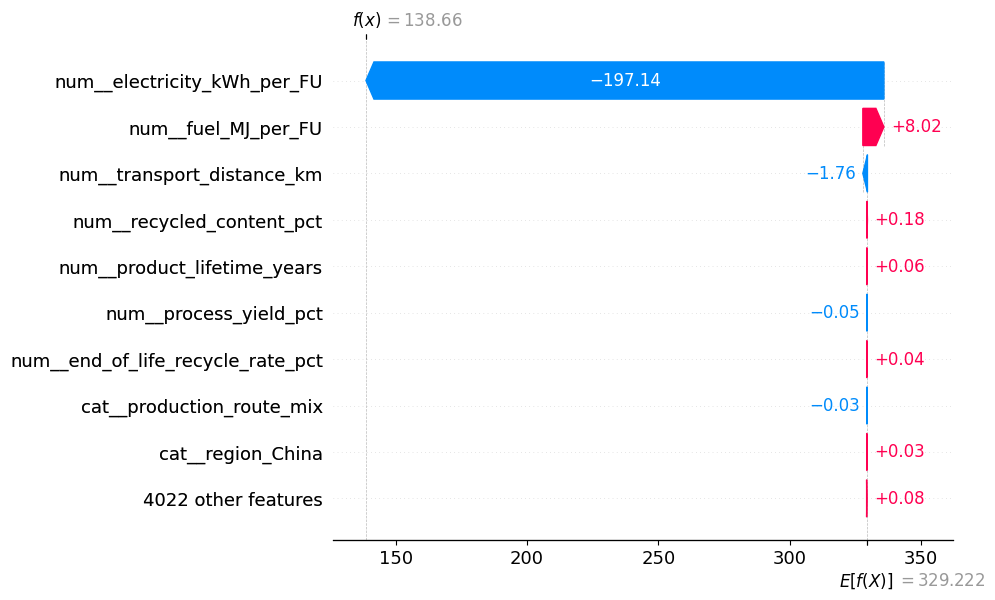


>>> Energy Prediction for sample <<<
Predicted Energy: 8873.40


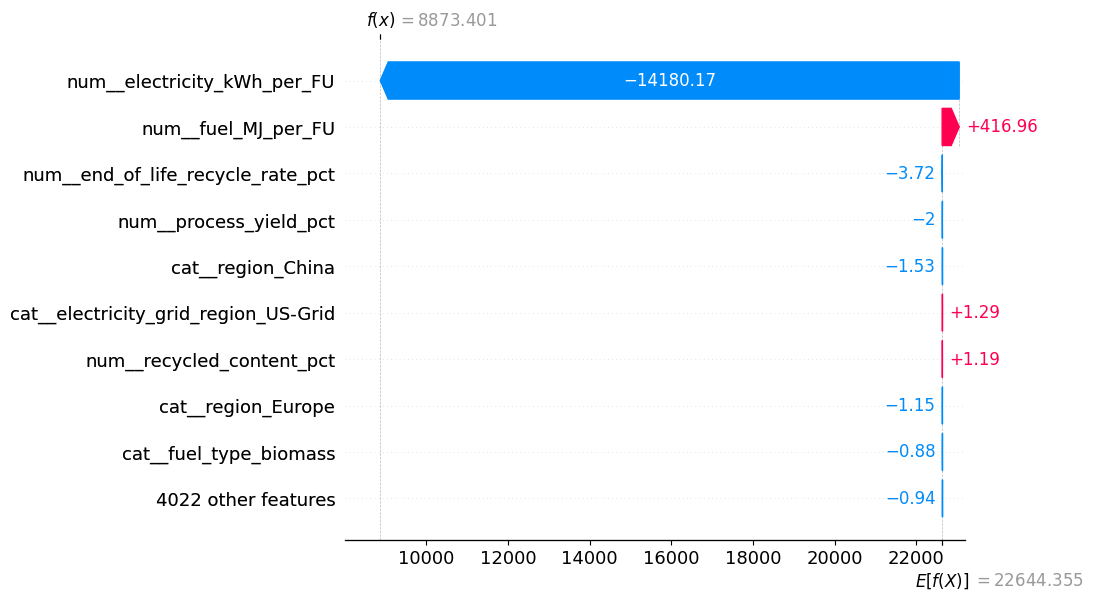


>>> Water Prediction for sample <<<
Predicted Water: 22.42


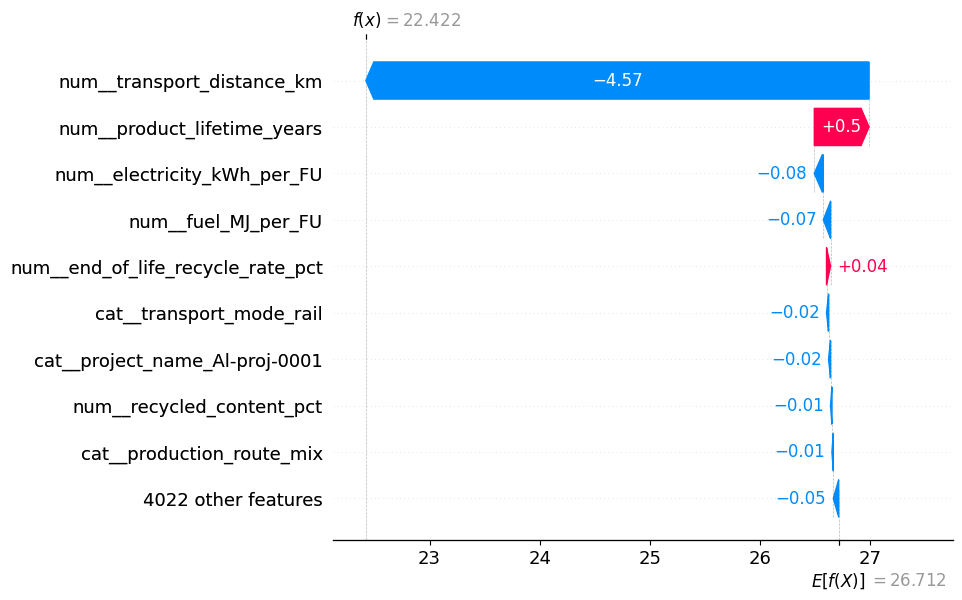

In [13]:
import shap
import matplotlib.pyplot as plt

# Fast SHAP local explainability for a single user input
models = {
    "CO₂": reg_co2,
    "Energy": reg_energy,
    "Water": reg_water
}

# Prepare one sample (first row)
sample = X.iloc[[0]]
sample_proc = preprocessor.transform(sample)
if hasattr(sample_proc, "toarray"):
    sample_proc = sample_proc.toarray()

feature_names = preprocessor.get_feature_names_out()

for name, model in models.items():
    print(f"\n>>> {name} Prediction for sample <<<")
    pred = model.predict(sample_proc)[0]
    print(f"Predicted {name}: {pred:.2f}")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(sample_proc)
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0], feature_names=feature_names)